# Presentación

## Introducción

**TUIA - Aprendizaje Automático 1** - 2023

---

**Trabajo Práctico Integrador** - "Predicción de lluvia en Australia"

**Alumnos:**  

*   Brisa Menescaldi
*   Miguel Mussi



## Objetivo


Familiarizarse con la librería scikit-learn y las herramientas que brinda para el pre-procesamiento de datos, la implementación de modelos y la evaluación de métricas, y con TensorFlow para el entrenamiento de redes neuronales.

## Dataset



El dataset se llama weatherAUS.csv y contiene información climática de Australia de los últimos diez años, incluyendo si para el día siguiente llovió o no y la cantidad de lluvia en las columnas ‘RainTomorrow’ y ‘RainfallTomorrow’. El objetivo es la predicción de estas dos variables en función del resto de las características que se consideren adecuadas.

Tiene una columna ‘Location’ que indica la ciudad y el objetivo es predecir la condición de lluvia en las ciudades de Sydney, SydneyAirport, Canberra, Melbourne y MelbourneAirport (costa sureste). Pueden considerarse como una única ubicación. Descartar el resto de los datos.

## Consignas





1. Armar grupos de hasta dos personas para la realización del trabajo práctico. Dar aviso al cuerpo docente del equipo. En caso de no tener compañero, informar al cuerpo docente.


2. Realizar un análisis descriptivo, que ayude a la comprensión del problema, de cada una de las variables involucradas en el problema detallando características, comportamiento y rango de variación.
Debe incluir:

> * Análisis y decisión sobre datos faltantes
* Visualización de datos (por ejemplo histogramas, scatterplots entre variables, diagramas de caja)
* ¿Está balanceado el dataset?
* Codificación de variables categóricas (si se van a utilizar para predicción).
* Matriz de correlación
* Selección de características para la predicción.
* Estandarización de datos.


3. Implementar la solución del problema de regresión con regresión lineal múltiple.

> * Probar con el método LinearRegression.
* Probar con métodos de gradiente descendiente.
* Probar con métodos de regularización (Lasso, Ridge, Elasticnet).
* Obtener las métricas adecuadas (entre R2 Score, MSE, RMSE, MAE, MAPE).


4. Implementar la solución del problema de clasificación con regresión logística.

> * Obtener las métricas adecuadas (entre Accuracy, precision, recall, F1 Score, ROC-AUC, entre otras).


5. Implementar las soluciones con una red neuronal.

> * Obtener las métricas adecuadas.


6. Mejorar la selección de hiperparámetros.

> * Probar validación cruzada.


7. MLOps (a definir).


8. Escribir una conclusión del trabajo

# Desarrollo

## Análisis exploratorio

In [1]:
#@title Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [2]:
#@title Sincronización con Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#@title DataFrame

# Path 1 - Referenciado a la carpeta de Drive
file_path= '/content/drive/MyDrive/UNR/4 - Aprendizaje Automático (IA41)/Trabajo Práctico (AA1)/weatherAUS.csv'
df_original = pd.read_csv(file_path, sep=',', engine='python')

# Path 2 - Mismo directorio
#df_original = pd.read_csv('weatherAUS.csv', sep=',', engine='python')

In [ ]:
df_original

In [ ]:
df_original.info()

In [ ]:
df_original.isna().sum()

In [ ]:
df_original.describe()

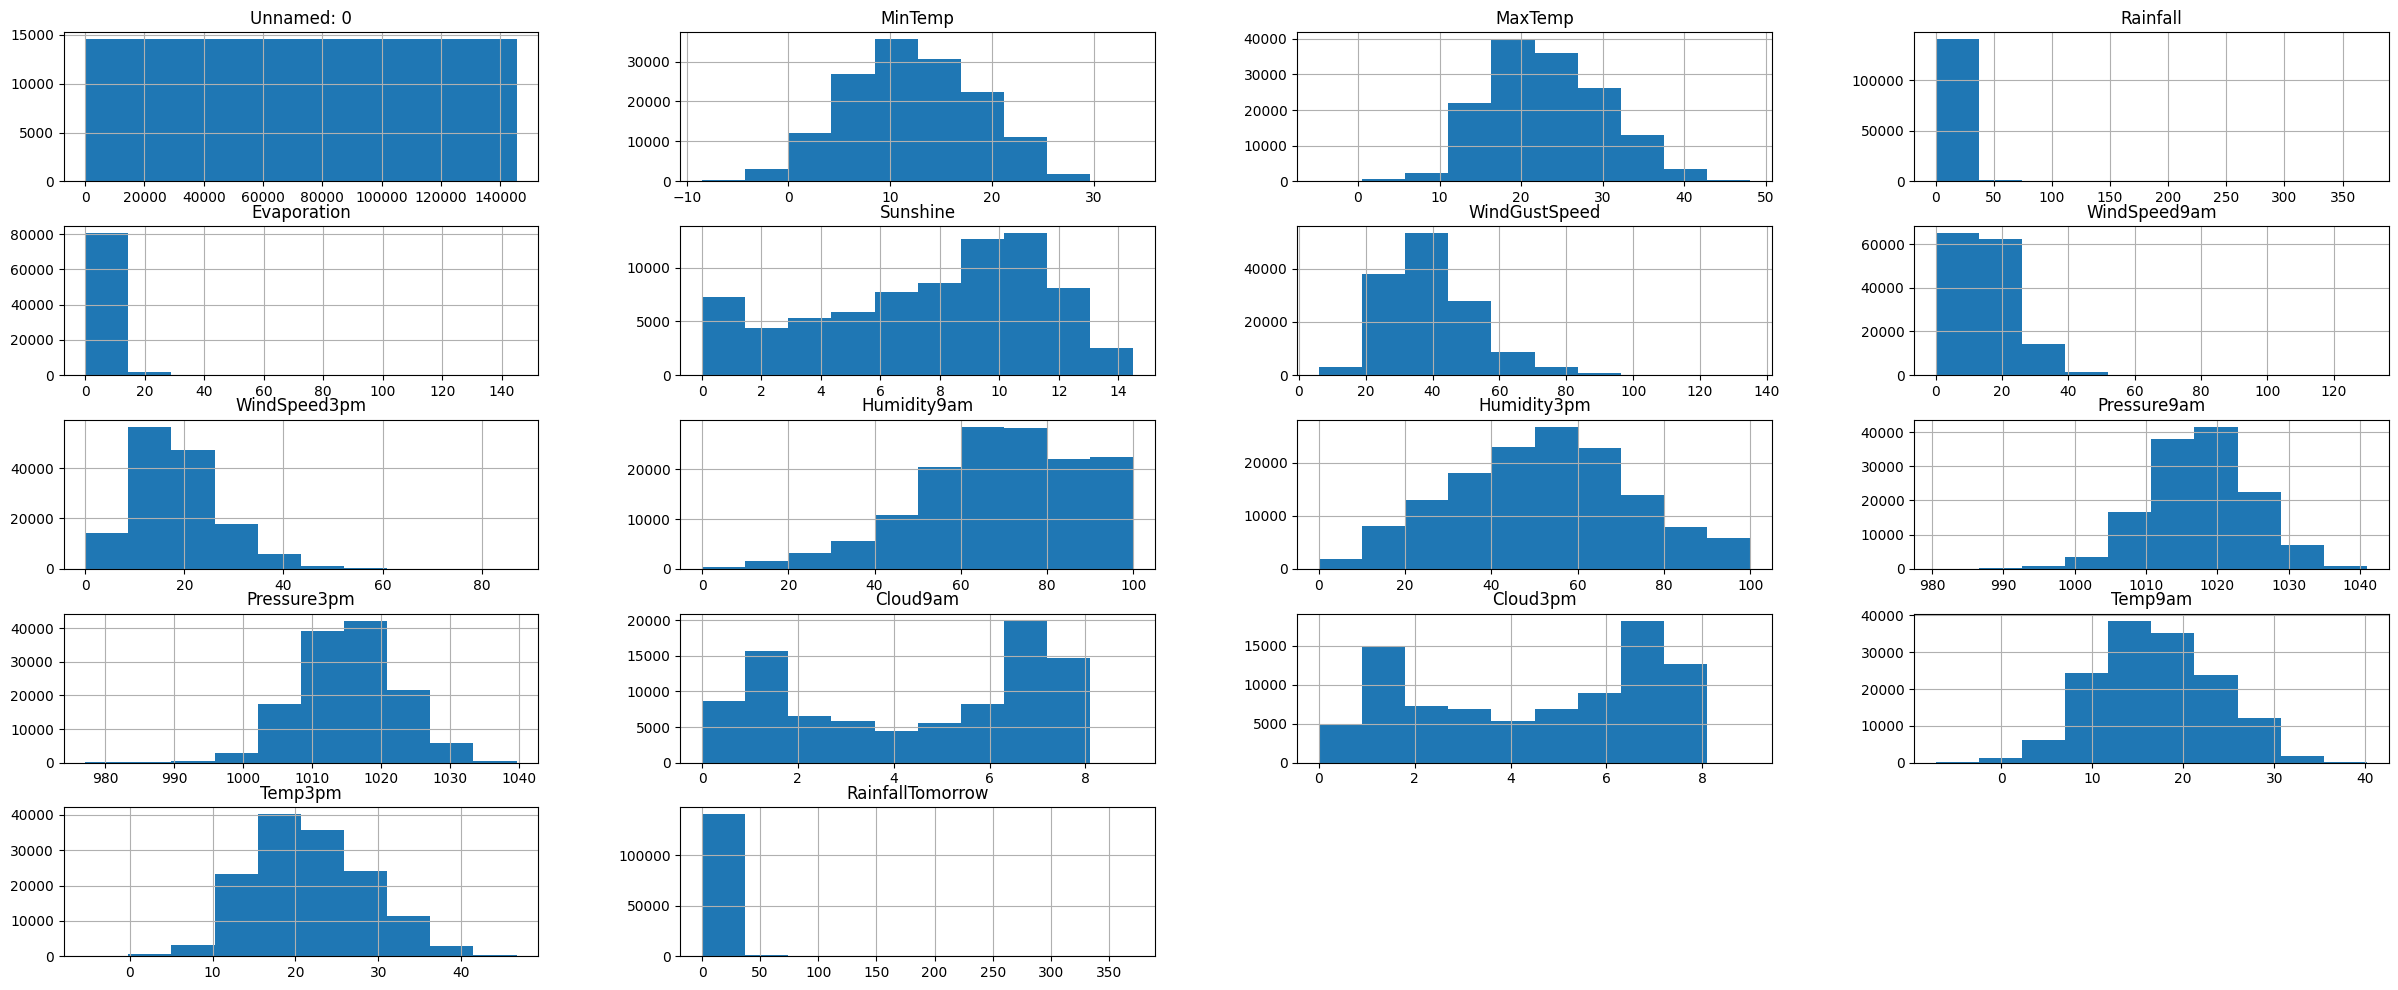

In [4]:
df_original.hist(figsize=(30,12))
plt.show()

In [5]:
# Eliminación de la primera columa
df_original = df_original.drop(['Unnamed: 0'], axis=1)

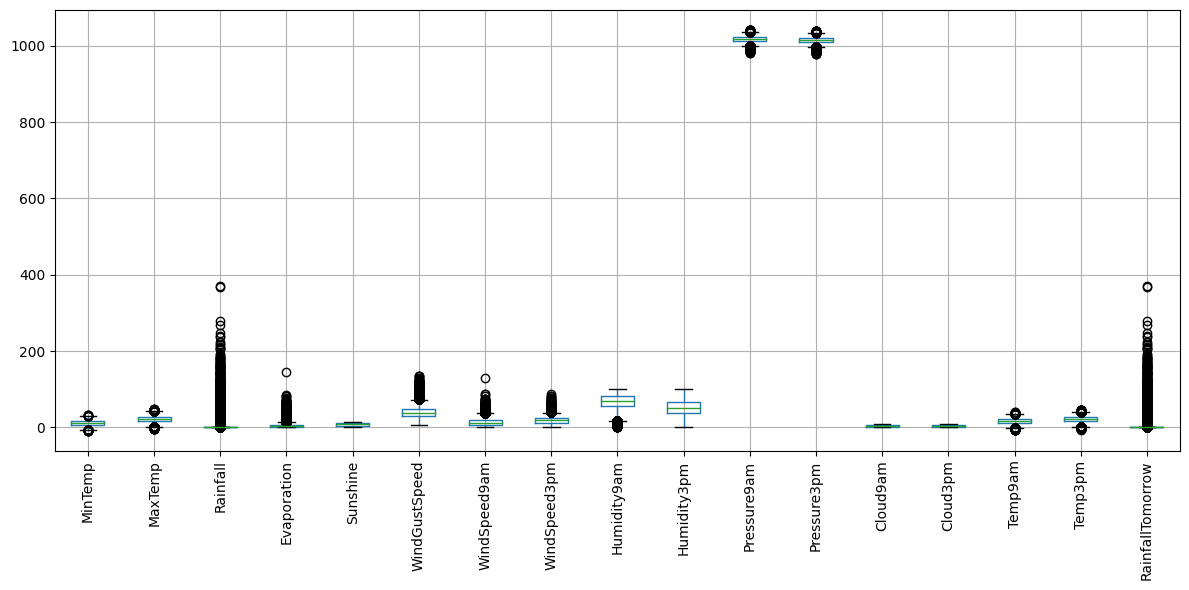

In [6]:
# Boxplot de los atributos a modo exploratorio
plt.figure(figsize=(12, 6))
df_original.boxplot(rot=90)
plt.tight_layout()  #para que las etiquetas no se superpongan
plt.show()

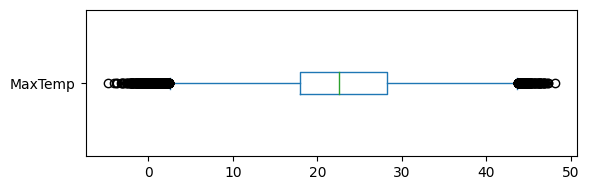

In [7]:
# Boxplot por atributo individual
# Para ver de más cerca las columnas con menos rango
target = 'MaxTemp'
plt.figure(figsize=(6, 2))
df_original[target].plot(kind='box', vert=False)
plt.tight_layout()
plt.show()

## Limpieza del Dataset

Se desea analizar únicamente los registros correspondientes a las ciudades de Sydney, SydneyAirport, Canberra, Melbourne y MelbourneAirport (costa sureste). Pueden considerarse como una única ubicación. Descartar el resto de los datos.

### Filtrado de ciudades

In [8]:
# Copia del DF original con los registros correspondientes a la costa sureste
ciudades_a_conservar = ['Sydney', 'SydneyAirport', 'Canberra', 'Melbourne', 'MelbourneAirport']
df = df_original[df_original['Location'].isin(ciudades_a_conservar)].copy()

In [9]:
df['Location'] = df['Location'].astype('category')
#df['RainToday'] = df['RainToday'].astype('category')
#df['RanTomorrow'] = df['RainTomorrow'].astype('category')

In [10]:
# Agrupar por etiqueta y contar la frecuencia
Location_frec = df['Location'].value_counts()
Location_frec

Canberra            3435
Sydney              3343
Melbourne           3192
MelbourneAirport    3008
SydneyAirport       3008
Name: Location, dtype: int64

### Tratamiento de datos nulos y faltantes

-- Opción A: Reemplazo por la media. Listado manual (NO USADA)

In [23]:
# Eliminación de registros con datos nulos/faltantes en variables booleanas
df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

# Se reemplaza valores nulos por las medias de cada columna que los contiene
df['MinTemp'].fillna(value=df['MinTemp'].mean(), inplace=True)
df['MaxTemp'].fillna(value=df['MaxTemp'].mean(), inplace=True)
df['Rainfall'].fillna(value=df['Rainfall'].mean(), inplace=True) # No quedan nulos acá
df['Evaporation'].fillna(value=df['Evaporation'].mean(), inplace=True)
df['Sunshine'].fillna(value=df['Sunshine'].mean(), inplace=True)
df['WindGustSpeed'].fillna(value=df['WindGustSpeed'].mean(), inplace=True)
df['WindSpeed9am'].fillna(value=df['WindSpeed9am'].mean(), inplace=True)
df['WindSpeed3pm'].fillna(value=df['WindSpeed3pm'].mean(), inplace=True)
df['Humidity9am'].fillna(value=df['Humidity9am'].mean(), inplace=True)
df['Humidity3pm'].fillna(value=df['Humidity3pm'].mean(), inplace=True)
df['Pressure9am'].fillna(value=df['Pressure9am'].mean(), inplace=True)
df['Pressure3pm'].fillna(value=df['Pressure3pm'].mean(), inplace=True)
df['Cloud9am'].fillna(value=df['Cloud9am'].mean(), inplace=True)
df['Cloud3pm'].fillna(value=df['Cloud3pm'].mean(), inplace=True)
df['Temp9am'].fillna(value=df['Temp9am'].mean(), inplace=True)
df['Temp3pm'].fillna(value=df['Temp3pm'].mean(), inplace=True)


-- Opción B: Reemplazo por la mediana. Listado iterativo

In [11]:
# Eliminación de registros con datos nulos/faltantes en variables booleanas
df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

In [12]:
# Lista de variables numéricas
t = (df.dtypes == "float64")
num_cols = list(t[t].index)
# Se reemplaza valores nulos por las medianas de cada columna que los contiene
for i in num_cols:
    df[i].fillna(df[i].median(), inplace=True)

### Recategorización de variables

In [13]:
# Reemplazo de Yes/No
df['RainToday'] = df['RainToday'].replace('Yes',1)
df['RainToday'] = df['RainToday'].replace('No',0)
df['RainTomorrow'] = df['RainTomorrow'].replace('Yes',1)
df['RainTomorrow'] = df['RainTomorrow'].replace('No',0)
df['RainToday'] = df['RainToday'].astype(int)
df['RainTomorrow'] = df['RainTomorrow'].astype(int)

# Reemplazo de Coordenadas
mapeo_coord = {
    'E': 0, 'N': 90, 'W': 180, 'S': 270,
    'NNE': 45, 'ENE': 22.5, 'ESE': 337.5, 'SSE': 292.5,
    'SSO': 247.5, 'OSO': 202.5, 'ONO': 112.5, 'NNO': 67.5}
df['WindGustDir'] = df['WindGustDir'].map(mapeo_coord)
df['WindDir9am'] = df['WindDir9am'].map(mapeo_coord)
df['WindDir3pm'] = df['WindDir3pm'].map(mapeo_coord)
df.dropna(subset=['WindGustDir', 'WindDir9am', 'WindDir3pm'], inplace=True)

### Reseteo de los índices del DF

In [14]:
# Reseteo de índices del dataframe
df = df.copy().reset_index(drop=True)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,2010-10-08,Sydney,13.8,19.5,0.0,4.6,9.5,337.5,35.0,45.0,...,56.0,1018.5,1016.3,6.0,1.0,16.5,19.1,0,0,0.0
1,2010-10-13,Sydney,16.7,23.9,0.4,7.0,2.8,45.0,39.0,180.0,...,64.0,1018.5,1016.3,7.0,5.0,17.8,22.9,0,1,2.0
2,2010-10-17,Sydney,9.9,24.0,0.0,6.6,12.1,180.0,41.0,180.0,...,30.0,1012.9,1011.3,6.0,6.0,14.7,23.3,0,0,0.0
3,2010-10-19,Sydney,14.0,19.0,3.8,6.4,0.8,292.5,37.0,292.5,...,53.0,1018.5,1026.2,8.0,7.0,14.7,17.1,1,0,0.2
4,2010-10-20,Sydney,12.9,20.3,0.2,3.0,10.9,22.5,37.0,180.0,...,57.0,1028.8,1025.6,3.0,1.0,16.9,19.8,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3121,2017-05-27,Melbourne,11.9,17.8,0.0,1.4,4.1,90.0,54.0,90.0,...,63.0,1017.5,1012.0,7.0,7.0,13.9,17.2,0,1,6.8
3122,2017-06-15,Melbourne,7.7,19.0,0.0,2.2,2.2,90.0,20.0,45.0,...,53.0,1027.7,1024.8,7.0,6.0,9.8,17.4,0,0,0.0
3123,2017-06-16,Melbourne,6.6,17.1,0.0,1.0,4.8,45.0,15.0,45.0,...,65.0,1026.4,1023.8,5.0,3.0,8.4,15.9,0,0,0.0
3124,2017-06-20,Melbourne,6.4,15.8,0.0,2.4,8.8,90.0,39.0,45.0,...,56.0,1028.1,1024.5,1.0,7.0,7.9,15.6,0,0,0.6


### Comprobaciones finales y verificaciones

In [ ]:
df.head()

In [ ]:
df.isna().sum()

In [ ]:
df.describe()

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MinTemp,3126.0,12.254766,5.618470,-6.8,8.125,12.2,16.600,30.5
MaxTemp,3126.0,22.111356,6.035873,8.4,17.600,21.8,25.975,46.4
Rainfall,3126.0,1.945489,6.965085,0.0,0.000,0.0,0.400,119.4
Evaporation,3126.0,5.039923,3.214767,0.0,2.600,4.2,6.800,23.8
Sunshine,3126.0,6.795553,3.818733,0.0,3.800,7.6,9.800,13.7
WindGustDir,3126.0,148.826775,108.479312,0.0,90.000,90.0,270.000,337.5
WindGustSpeed,3126.0,46.368202,15.929919,11.0,35.000,43.0,57.000,107.0
WindDir9am,3126.0,158.845969,100.389192,0.0,90.000,90.0,270.000,337.5
WindDir3pm,3126.0,151.842610,118.338446,0.0,45.000,90.0,270.000,337.5
WindSpeed9am,3126.0,20.328855,12.143014,2.0,11.000,17.0,28.000,67.0


In [ ]:
df.info()

# Visualizaciones

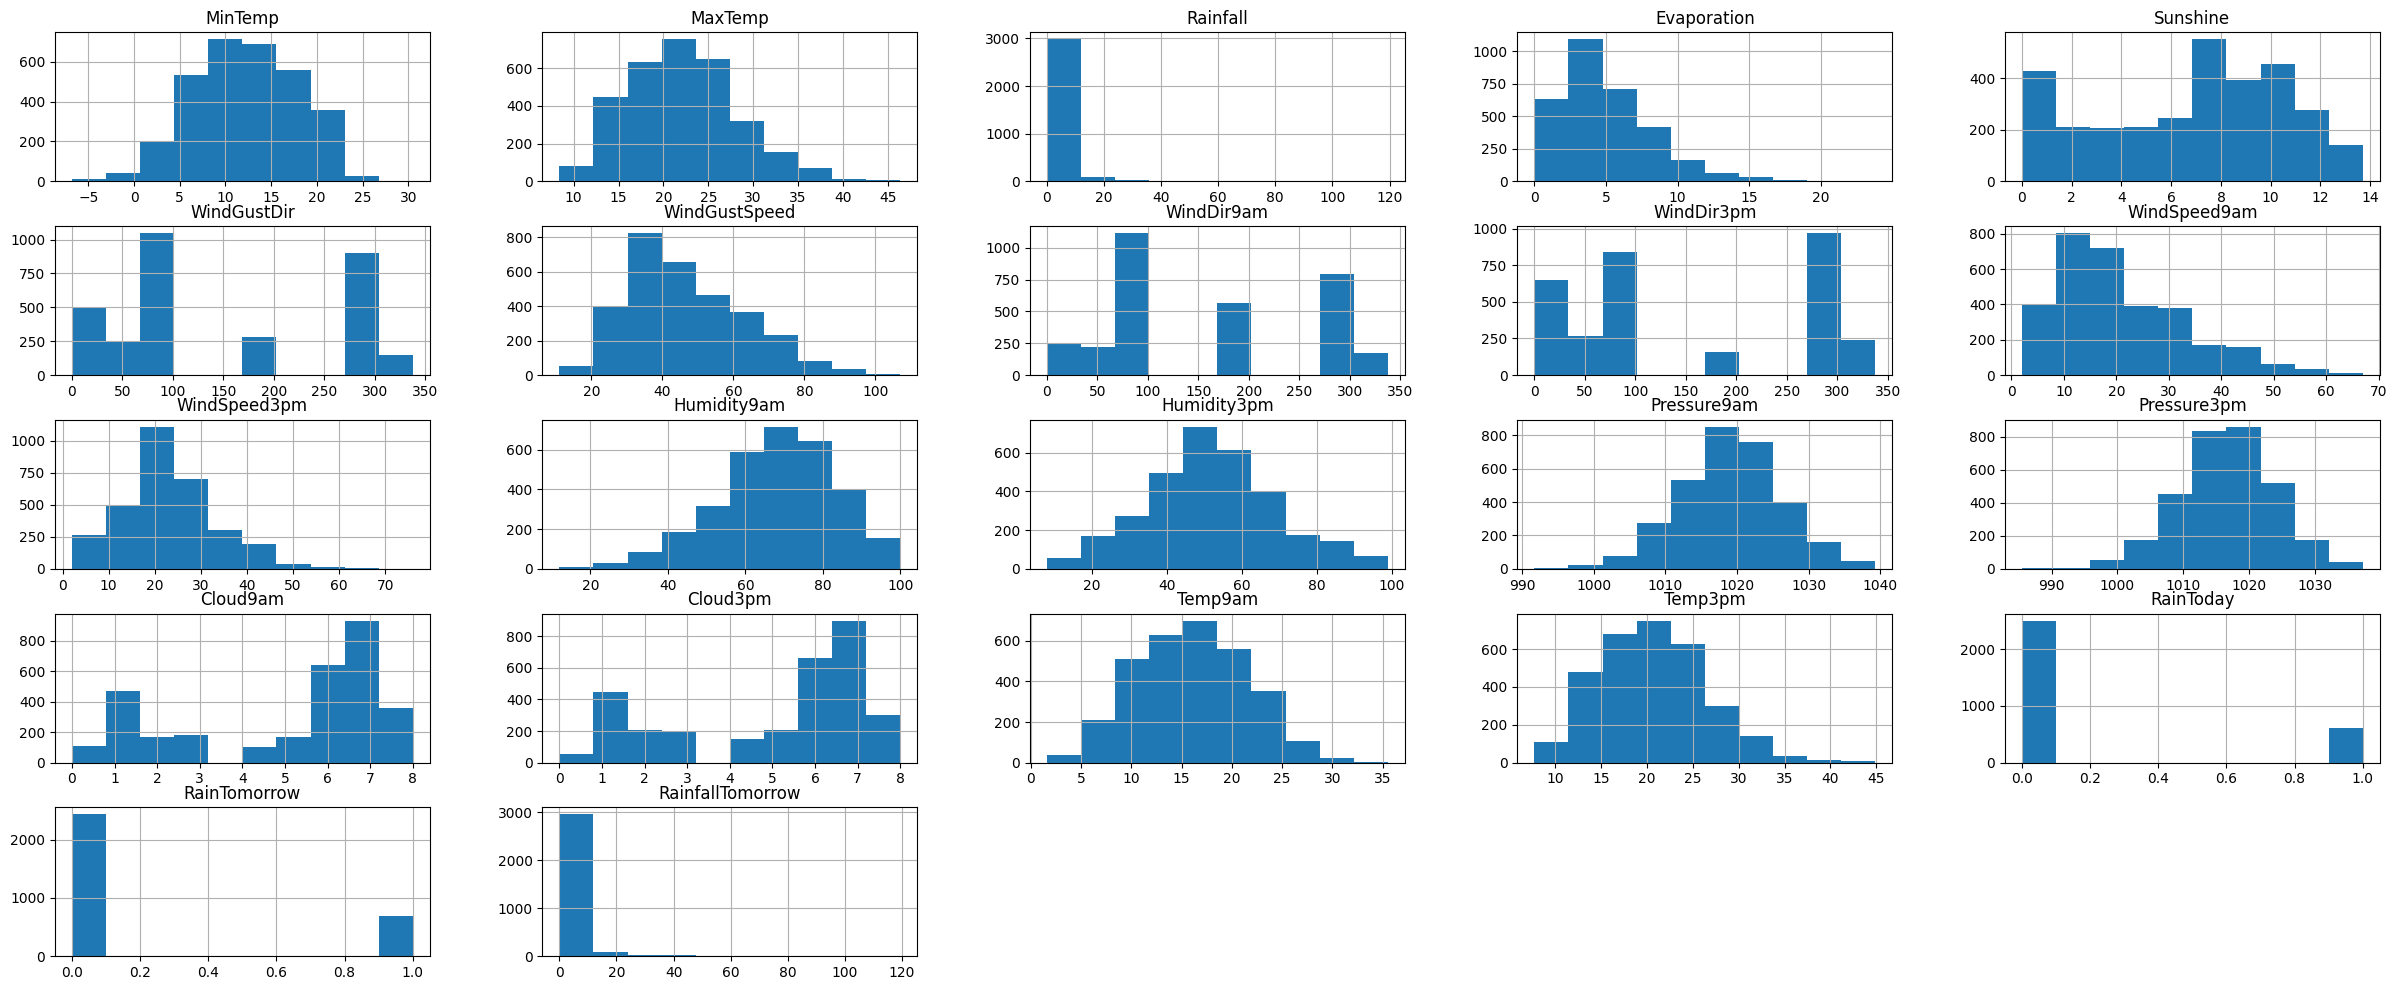

In [16]:
#@title Histogramas
df.hist(figsize=(30,12))
plt.show()

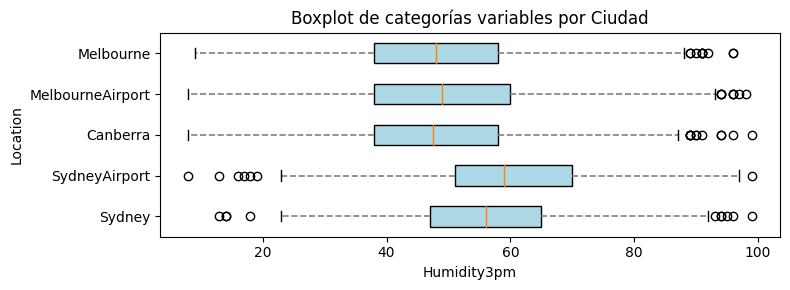

In [17]:
#@title Boxplot de atributos variables

# Variable a analizar (Disponibles)
# Date, Location, MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine
# WindGustDir, WindGustSpeed, WindDir9am, WindDir3pm, WindSpeed9am
# WindSpeed3pm, Humidity9am, Humidity3pm, Pressure9am, Pressure3pm
# Cloud9am, Cloud3pm, Temp9am, Temp3pm, RainToday, RainTomorrow, RainfallTomorrow
target = 'Humidity3pm'

# Configuración de estilo y tamaño del gráfico
plt.figure(figsize=(8, 3))

# Crear el gráfico de boxplot con barrios en el eje vertical y precios en el eje horizontal
boxplot = plt.boxplot([df[df['Location'] == location][target] for location in df['Location'].unique()],
                      vert=False,  # Boxplots horizontales
                      patch_artist=True)  # Para personalizar colores de los cuadros

# Personalizar el color de los cuadros (box) y los bigotes (whisker)
for box in boxplot['boxes']:
    box.set(facecolor='lightblue')
for whisker in boxplot['whiskers']:
    whisker.set(color='gray', linewidth=1.2, linestyle='--')

# Etiquetas y título del gráfico
plt.yticks(range(1, len(df['Location'].unique()) + 1), df['Location'].unique())  # Etiquetas en el eje y
plt.xlabel(target)
plt.ylabel('Location')
plt.title('Boxplot de categorías variables por Ciudad')

# Desactivar notación científica en el eje horizontal
# plt.ticklabel_format(axis='x', style='plain')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

0    2432
1     694
Name: RainTomorrow, dtype: int64


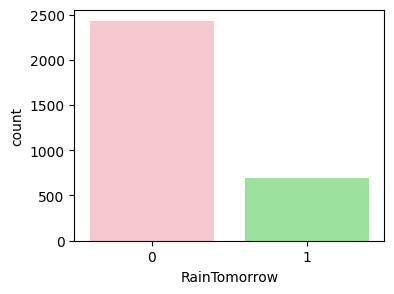

In [18]:
#@title Balance de RainTomorrow (No/Yes)
cols= ["pink","lightgreen"]
plt.figure(figsize=(4, 3))
sns.countplot(x=df["RainTomorrow"], palette= cols)
print(df['RainTomorrow'].value_counts())
plt.show()

# Correlaciones

In [ ]:
corr = df.corr()
# corr

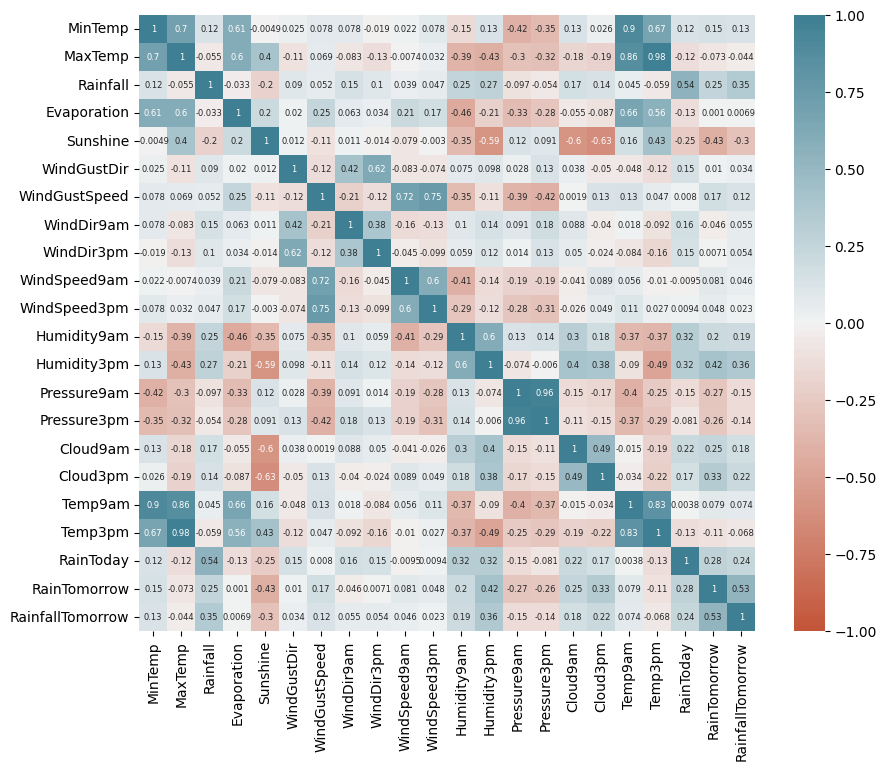

In [20]:
#@title Matriz de Correlación
plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot = True,
    annot_kws = {'size': 6}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='center'
)
plt.show()

# Estandarización

In [21]:
#@title Estandarización Z-score
df_sub = df.drop(['Location', 'Date'], axis=1) # Eliminación de variables no numéricas
scaler = StandardScaler() # Creación del objeto scaler
X_scaled = scaler.fit_transform(df_sub) # Cálculo de la media y la desviación estándar y aplicación de la transformación de estandarización.
df_std = pd.DataFrame(X_scaled, columns=df_sub.columns)
df_std

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,0.275071,-0.432709,-0.279365,-0.136866,0.708318,1.739534,-0.713753,-1.134228,1.569119,-1.344927,...,0.232726,-0.080386,-0.040588,0.367951,-1.674563,0.085950,-0.260089,-0.496399,-0.534193,-0.293607
1,0.791309,0.296383,-0.221926,0.609808,-1.046471,-0.957264,-0.462613,0.210754,-1.093164,-1.097832,...,0.705821,-0.080386,-0.040588,0.762672,-0.020242,0.323831,0.401781,-0.496399,1.871984,-0.039850
2,-0.419179,0.312953,-0.279365,0.485362,1.389281,0.287412,-0.337043,0.210754,1.188793,0.302374,...,-1.304833,-0.872061,-0.741256,0.367951,0.393338,-0.243425,0.471452,-0.496399,-0.534193,-0.293607
3,0.310674,-0.515560,0.266301,0.423139,-1.570288,1.324642,-0.588183,1.331572,1.188793,-0.274181,...,0.055316,-0.080386,1.346735,1.157393,0.806918,-0.243425,-0.608442,2.014510,-0.534193,-0.268231
4,0.114860,-0.300146,-0.250646,-0.634649,1.074991,-1.164710,-0.588183,0.210754,-1.283327,-0.768372,...,0.291863,1.375731,1.262655,-0.816211,-1.674563,0.159144,-0.138165,-0.496399,-0.534193,-0.293607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3121,-0.063153,-0.714403,-0.279365,-1.132432,-0.705989,-0.542372,0.479162,-0.685900,-0.522675,-0.027086,...,0.646684,-0.221756,-0.643162,0.762672,0.806918,-0.389814,-0.591024,-0.496399,1.871984,0.569169
3122,-0.810807,-0.515560,-0.279365,-0.883541,-1.203616,-0.542372,-1.655528,-1.134228,-0.522675,-0.933102,...,0.055316,1.220223,1.150548,0.762672,0.393338,-1.140056,-0.556189,-0.496399,-0.534193,-0.293607
3123,-1.006621,-0.830395,-0.279365,-1.256878,-0.522653,-0.957264,-1.969453,-1.134228,0.998630,-0.933102,...,0.764958,1.036442,1.010414,-0.026769,-0.847403,-1.396236,-0.817453,-0.496399,-0.534193,-0.293607
3124,-1.042224,-1.045808,-0.279365,-0.821318,0.524982,-0.542372,-0.462613,-1.134228,-0.522675,-0.768372,...,0.232726,1.276772,1.108508,-1.605652,0.806918,-1.487729,-0.869706,-0.496399,-0.534193,-0.217480


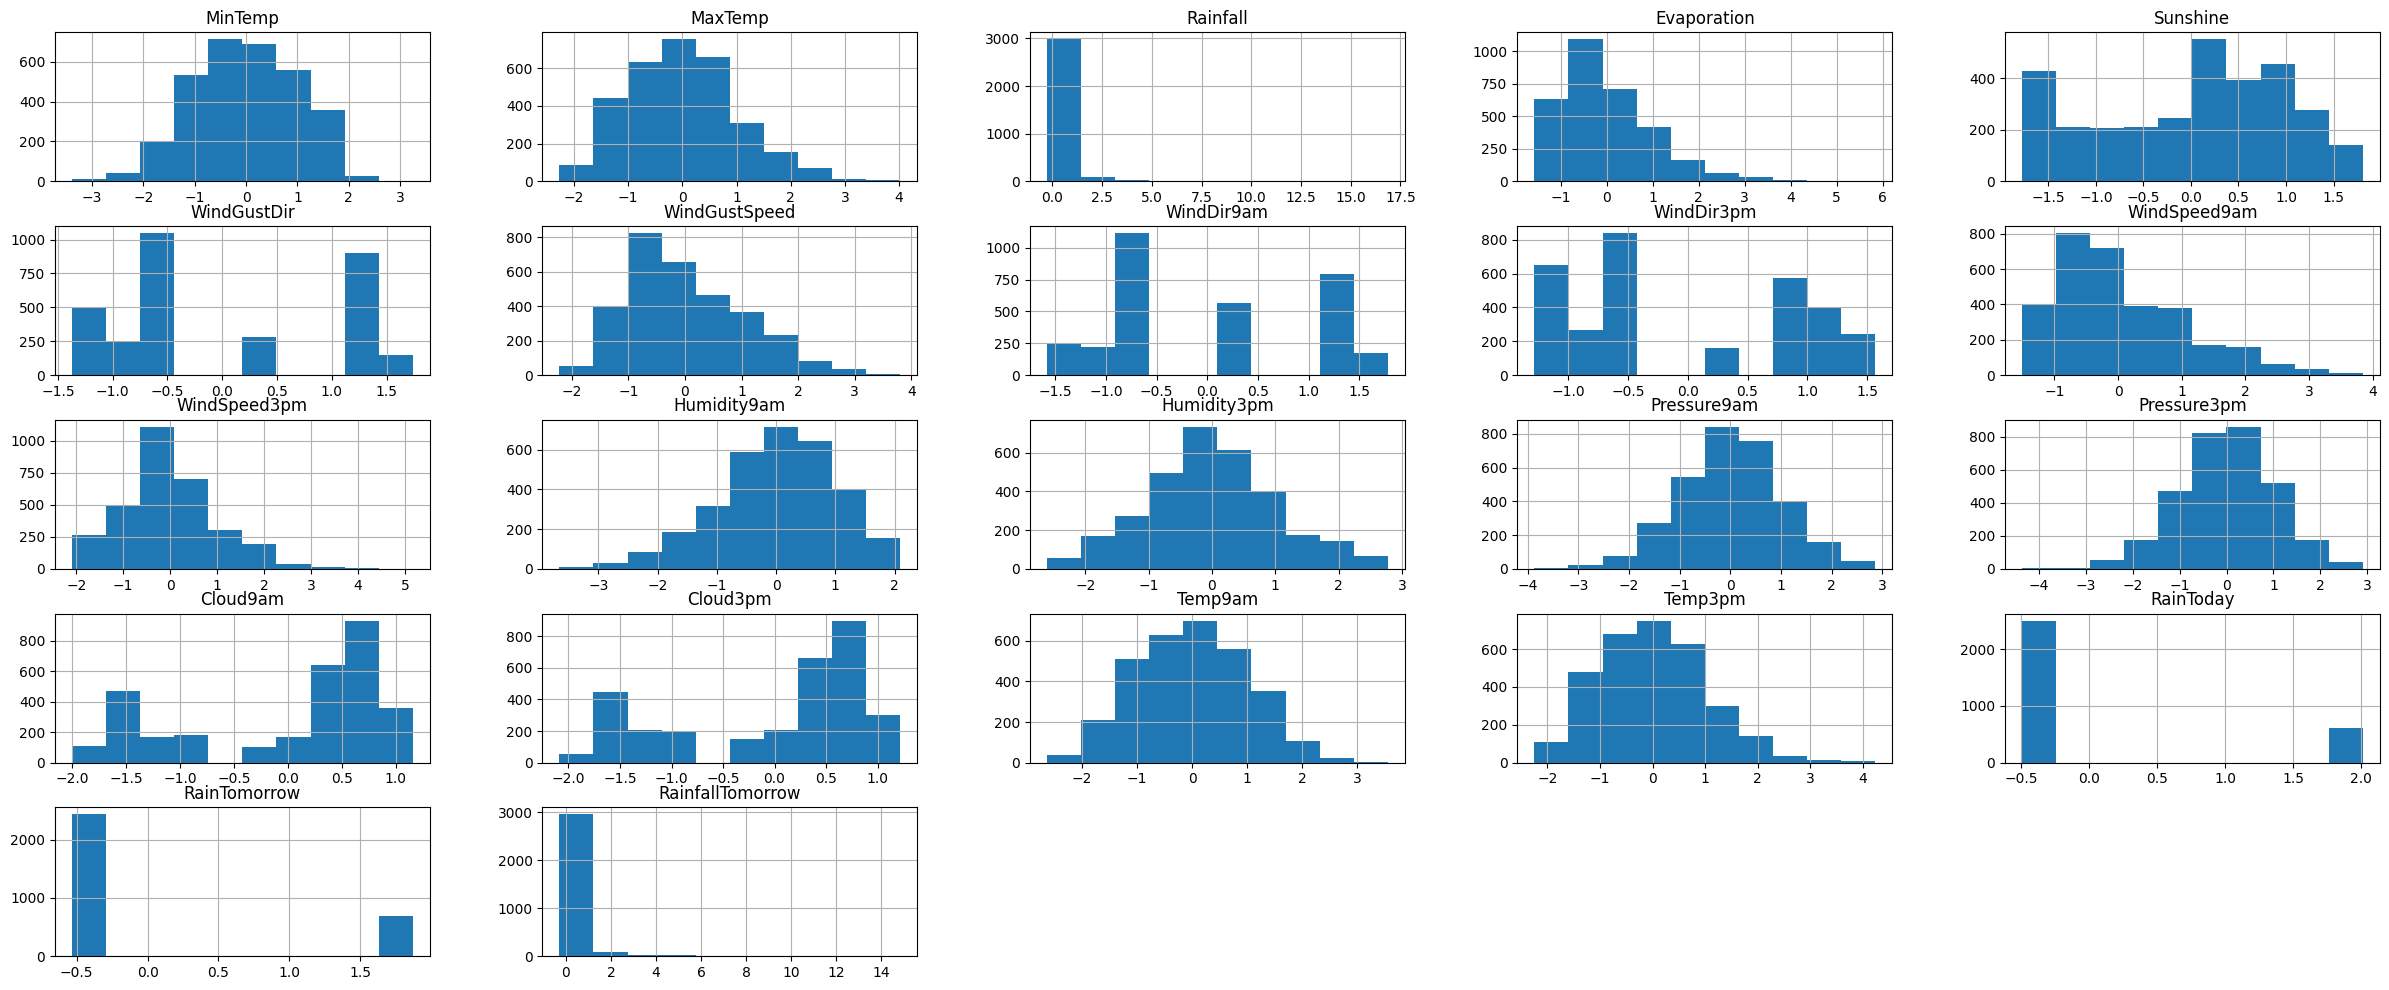

In [22]:
#@title Histogramas con las variables estandarizadas
df_std.hist(figsize=(30,12))
plt.show()

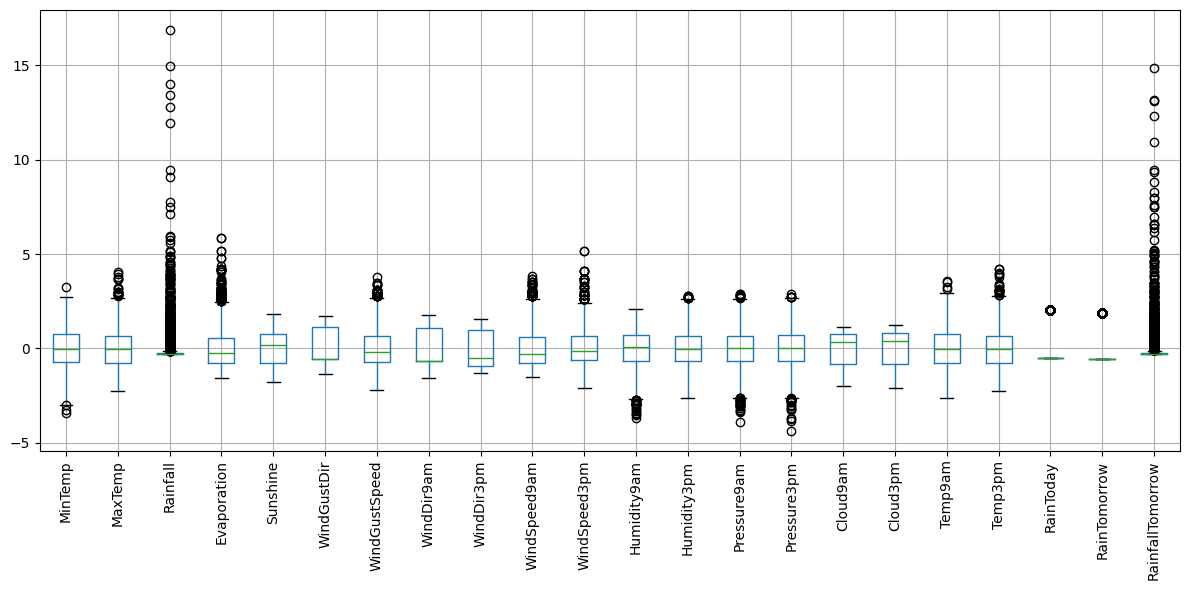

In [23]:
# Boxplot de las variables estandarizadas
plt.figure(figsize=(12, 6))
df_std.boxplot(rot=90)
plt.tight_layout()  #para que las etiquetas no se superpongan
plt.show()

In [ ]:
df_std.describe().round(3)

# Detección y filtrado de Outliers

In [24]:
df_out = df_std.drop(['RainTomorrow'], axis=1)
target = df['RainTomorrow']

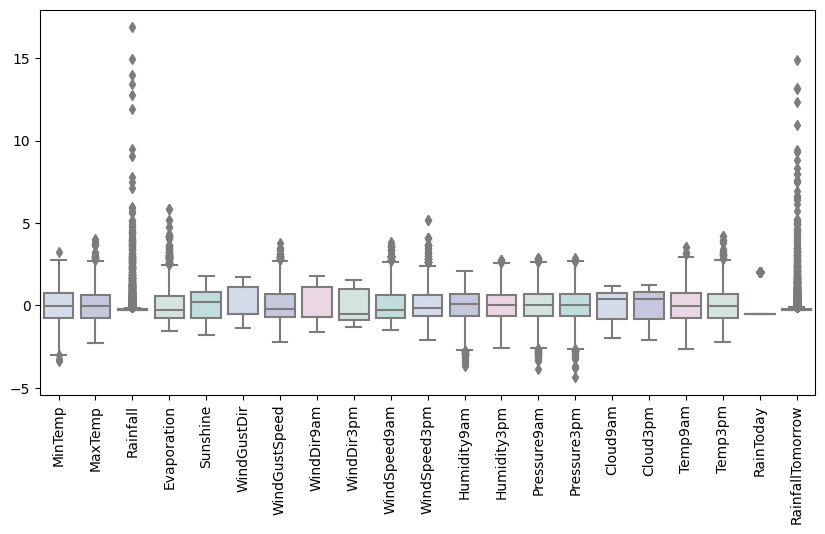

In [25]:
# Detección de outliers
# Boxplot con variables escaladas
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(10,5))
sns.boxplot(data = df_out,palette = colours)
plt.xticks(rotation=90)
plt.show()

In [26]:
# Eliminación de outliers
# full data for
df_out["RainTomorrow"] = target

#Dropping with outlier
df_out = df_out[(df_out["MinTemp"]<2.3)&(df_out["MinTemp"]>-2.3)]
df_out = df_out[(df_out["MaxTemp"]<2.3)&(df_out["MaxTemp"]>-2)]
df_out = df_out[(df_out["Rainfall"]<3)]  # <<< ACOTAR >>>
df_out = df_out[(df_out["Evaporation"]<2.8)]
df_out = df_out[(df_out["Sunshine"]<2.1)]
df_out = df_out[(df_out["WindGustSpeed"]<4)&(df_out["WindGustSpeed"]>-4)]
df_out = df_out[(df_out["WindSpeed9am"]<4)]
df_out = df_out[(df_out["WindSpeed3pm"]<2.5)]
df_out = df_out[(df_out["Humidity9am"]>-3)]
df_out = df_out[(df_out["Humidity3pm"]>-2.2)]
df_out = df_out[(df_out["Pressure9am"]< 2)&(df_out["Pressure9am"]>-2.7)]
df_out = df_out[(df_out["Pressure3pm"]< 2)&(df_out["Pressure3pm"]>-2.7)]
df_out = df_out[(df_out["Cloud9am"]<1.8)]
df_out = df_out[(df_out["Cloud3pm"]<2)]
df_out = df_out[(df_out["Temp9am"]<2.3)&(df_out["Temp9am"]>-2)]
df_out = df_out[(df_out["Temp3pm"]<2.3)&(df_out["Temp3pm"]>-2)]
df_out = df_out[(df_out["RainfallTomorrow"]<3)]  # <<< ACOTAR >>>

df_out.shape

(2683, 22)

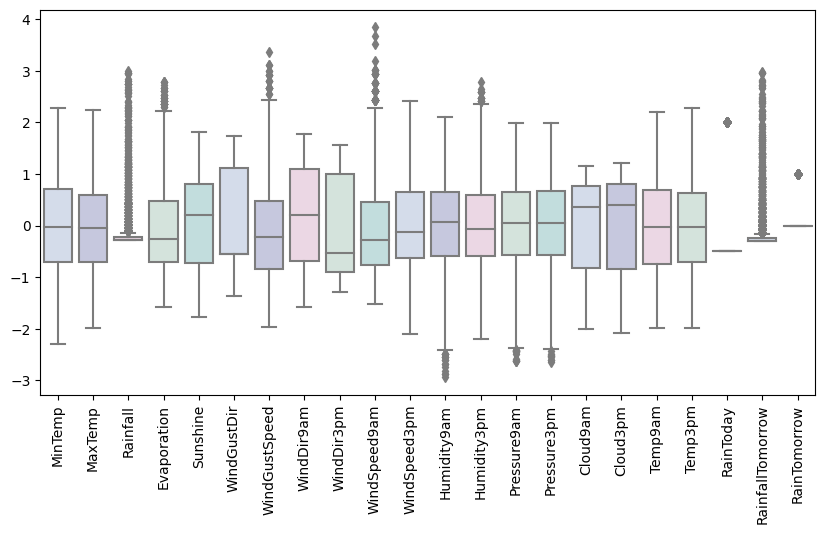

In [27]:
# Boxplot con variables escaladas sin outliers
colours = ["#D0DBEE", "#C2C4E2", "#EED4E5", "#D1E6DC", "#BDE2E2"]
plt.figure(figsize=(10,5))
sns.boxplot(data = df_out,palette = colours)
plt.xticks(rotation=90)
plt.show()

# Análisis de las distribuciones

In [28]:
columnas = [col for col in df_out.columns if ((col != 'RainTomorrow') & (col != 'RainfallTomorrow'))]

<Figure size 1200x800 with 0 Axes>

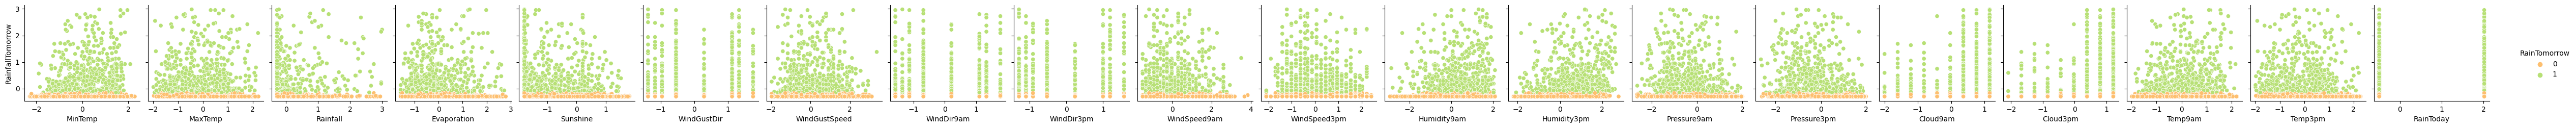

In [29]:
plt.figure(figsize=(12, 8))
sns.pairplot(df_out, hue='RainTomorrow',x_vars=columnas,y_vars='RainfallTomorrow', palette='RdYlGn')
plt.show()

<Figure size 1200x800 with 0 Axes>

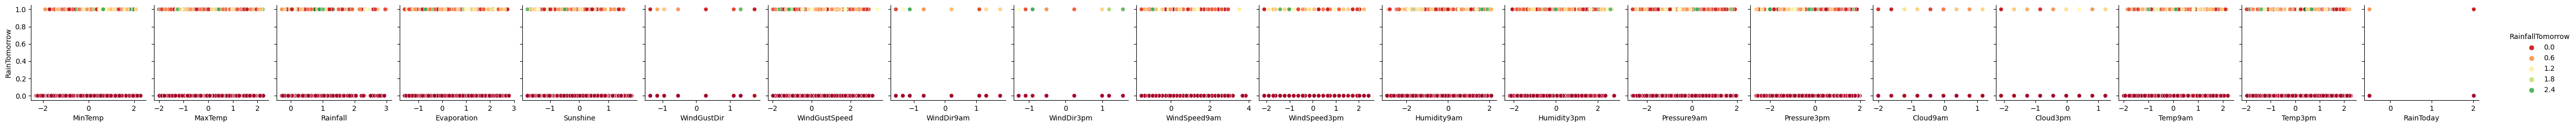

In [30]:
plt.figure(figsize=(12, 8))
sns.pairplot(df_out, hue='RainfallTomorrow',x_vars=columnas,y_vars='RainTomorrow', palette='RdYlGn')
plt.show()

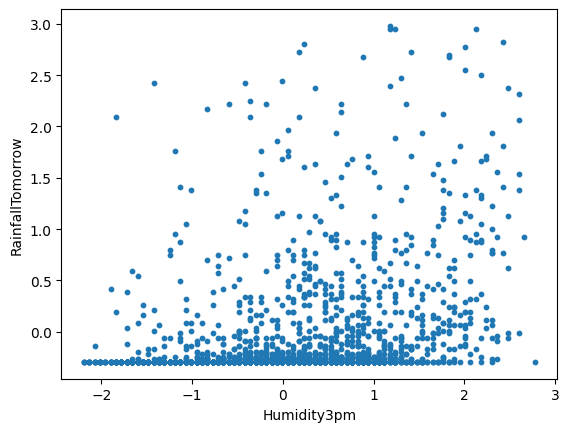

<Figure size 300x200 with 0 Axes>

In [31]:
# Relación entre la Humedad a las 3pm y la cantidad de lluvia de mañana
f ,ax = plt.subplots()
plt.figure(figsize=(3, 2))
ax.scatter(df_out['Humidity3pm'], df_out['RainfallTomorrow'], s= 10)
ax.set_xlabel('Humidity3pm')
ax.set_ylabel('RainfallTomorrow')
plt.show()

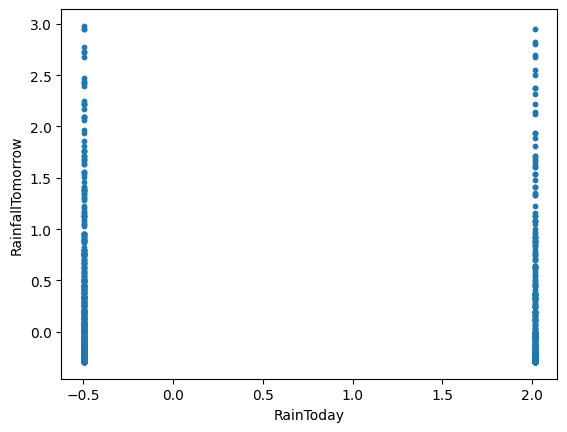

<Figure size 300x200 with 0 Axes>

In [32]:
# Relación entre la lluvia de hoy y la cantidad de mañana
f ,ax = plt.subplots()
plt.figure(figsize=(3, 2))
ax.scatter(df_out['RainToday'], df_out['RainfallTomorrow'], s= 10)
ax.set_xlabel('RainToday')
ax.set_ylabel('RainfallTomorrow')
plt.show()

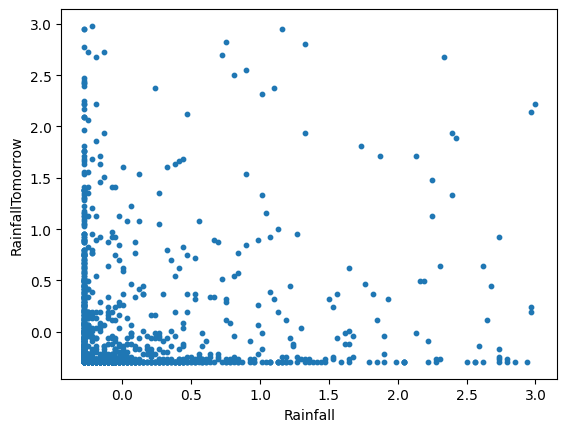

<Figure size 300x200 with 0 Axes>

In [33]:
# Relación entre la cantidad de lluvia de hoy y la cantidad de mañana
f ,ax = plt.subplots()
plt.figure(figsize=(3, 2))
ax.scatter(df_out['Rainfall'], df_out['RainfallTomorrow'], s= 10)
ax.set_xlabel('Rainfall')
ax.set_ylabel('RainfallTomorrow')
plt.show()

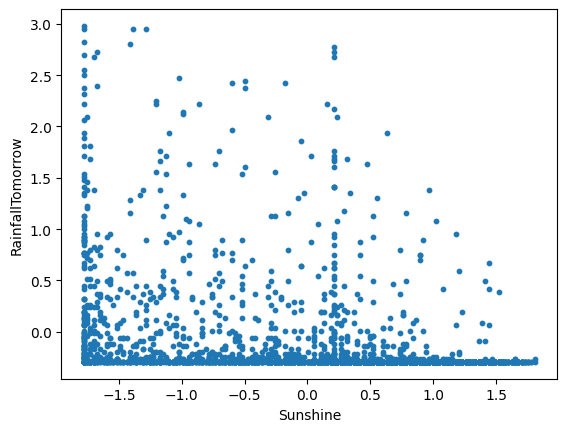

<Figure size 300x200 with 0 Axes>

In [34]:
# Relación entre la cantidad de lluvia de hoy y la cantidad de mañana
f ,ax = plt.subplots()
plt.figure(figsize=(3, 2))
ax.scatter(df_out['Sunshine'], df_out['RainfallTomorrow'], s= 10)
ax.set_xlabel('Sunshine')
ax.set_ylabel('RainfallTomorrow')
plt.show()

# Regresión Lineal

NOTA: Las variables a predecir, según la consigna, son "RainTomorrow" y "RainfallTomorrow". Analizando los coeficientes de correlación entre esas variables y el resto (se descartan las que corresponden al día siguiente pues no admiten la posibilidad de predecir), las candidatas a ser elegidas para predecirlas son las siguientes.

* RainTomorrow: Humidity3pm (0,42) - Cloud3pm (0.34) - Rainfall (0,25) - Sunshine (-0,43)

* RainfallTomorrow: Humidity3pm (0,36) - Cloud3pm (0.35) - Rainfall (0,25) - Sunshine (-0,3)

Comenzamos con la variable "Humidity3pm" para analizar su relación con la variable a predecir "RainfallTomorrow".

## Variable a predecir: RainfallTomorrow

### Relación "Humidity3pm" con "RainfallTomorrow"

Error cuadrático medio (MSE): 0.20
Coeficiente de determinación (R^2): 0.12


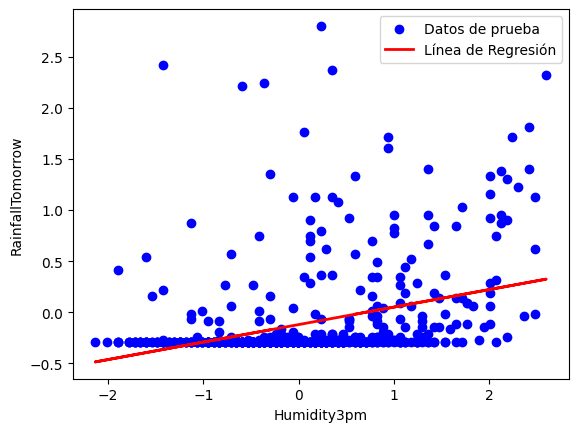

In [35]:
#@title Humidity3pm
# Selecciona las características (X) y la variable objetivo (y)
X = df_out[['Humidity3pm']]
y = df_out['RainfallTomorrow']

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo de regresión lineal
model = LinearRegression()

# Entrenamiento del modelo (Train)
model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba (Test)
y_pred = model.predict(X_test)

# Métricas del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Outputs
print(f'Error cuadrático medio (MSE): {mse:.2f}')
print(f'Coeficiente de determinación (R^2): {r2:.2f}')

# Grafica los datos y la línea de regresión
plt.scatter(X_test, y_test, color='blue', label='Datos de prueba')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Línea de Regresión')
plt.xlabel('Humidity3pm')
plt.ylabel('RainfallTomorrow')
plt.legend()
plt.show()

### Relación "Cloud3pm" con "RainfallTomorrow"

Error cuadrático medio (MSE): 0.21
Coeficiente de determinación (R^2): 0.07


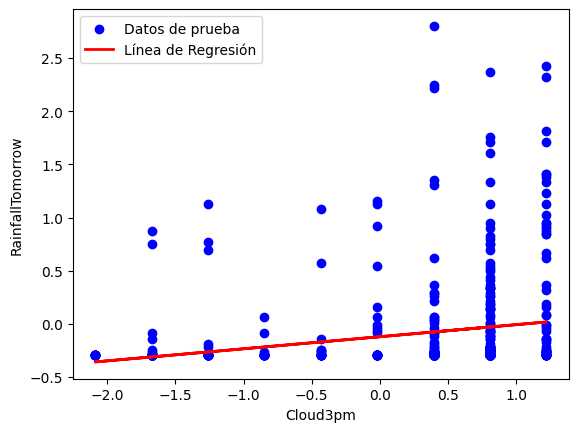

In [36]:
#@title Cloud3pm
# Selecciona las características (X) y la variable objetivo (y)
X = df_out[['Cloud3pm']]
y = df_out['RainfallTomorrow']

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo de regresión lineal
model = LinearRegression()

# Entrenamiento del modelo (Train)
model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba (Test)
y_pred = model.predict(X_test)

# Métricas del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Outputs
print(f'Error cuadrático medio (MSE): {mse:.2f}')
print(f'Coeficiente de determinación (R^2): {r2:.2f}')

# Grafica los datos y la línea de regresión
plt.scatter(X_test, y_test, color='blue', label='Datos de prueba')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Línea de Regresión')
plt.xlabel('Cloud3pm')
plt.ylabel('RainfallTomorrow')
plt.legend()
plt.show()

### Relación "Rainfall" con "RainfallTomorrow"

Error cuadrático medio (MSE): 0.21
Coeficiente de determinación (R^2): 0.05


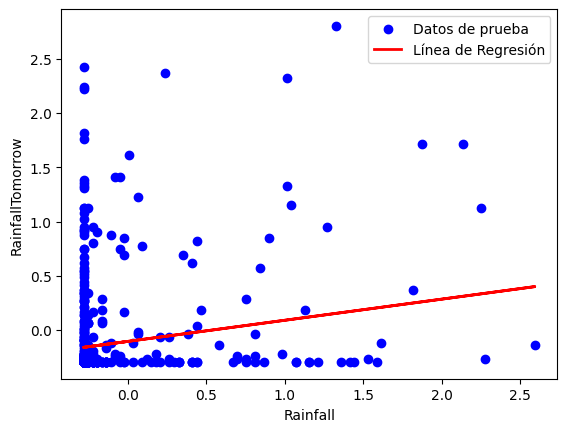

In [37]:
#@title Rainfall
# Selecciona las características (X) y la variable objetivo (y)
X = df_out[['Rainfall']]
y = df_out['RainfallTomorrow']

# Datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo de regresión lineal
model = LinearRegression()

# Entrenamiento del modelo (Train)
model.fit(X_train, y_train)

# Predicciones en el conjunto de prueba (Test)
y_pred = model.predict(X_test)

# Métricas del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Outputs
print(f'Error cuadrático medio (MSE): {mse:.2f}')
print(f'Coeficiente de determinación (R^2): {r2:.2f}')

# Grafica los datos y la línea de regresión
plt.scatter(X_test, y_test, color='blue', label='Datos de prueba')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Línea de Regresión')
plt.xlabel('Rainfall')
plt.ylabel('RainfallTomorrow')
plt.legend()
plt.show()

# Regresión Lineal con Gradiente Descendiente

In [38]:
#@title Gradiente Descendiente
# Selecciona las características (X) y la variable objetivo (y)
X = df_out[['Humidity3pm']]
y = df_out['RainfallTomorrow']

# Datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escala las características para el gradiente descendiente
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Creación del modelo
model_sgd = SGDRegressor(max_iter=10000, random_state=42)

# Entrenamiento del modelo (Train)
model_sgd.fit(X_train_scaled, y_train)

# Predicciones en el conjunto de prueba (Test)
y_pred_sgd = model_sgd.predict(X_test_scaled)

# Métricas del modelo
mse_sgd = mean_squared_error(y_test, y_pred_sgd)
r2_sgd = r2_score(y_test, y_pred_sgd)

# Outputs
print('Resultados con Gradiente Descendiente:')
print(f'Error cuadrático medio (MSE): {mse_sgd:.2f}')
print(f'Coeficiente de determinación (R^2): {r2_sgd:.2f}')


Resultados con Gradiente Descendiente:
Error cuadrático medio (MSE): 0.20
Coeficiente de determinación (R^2): 0.12


# Regularización Lasso, Ridge, ElasticNet

In [39]:
#@title Lasso, Ridge, ElasticNet
# Creación de los modelos (Lasso, Ridge, Elastic Net)
model_lasso = Lasso(alpha=0.1) # 0,01
model_ridge = Ridge(alpha=0.1) # 1.0
model_elastic = ElasticNet(alpha=0.1, l1_ratio=0.5) #0.01 - 0.5

# Entrenamiento de los modelos (Train)
model_lasso.fit(X_train_scaled, y_train)
model_ridge.fit(X_train_scaled, y_train)
model_elastic.fit(X_train_scaled, y_train)

# Predicciones en el conjunto de prueba (Test)
y_pred_lasso = model_lasso.predict(X_test_scaled)
y_pred_ridge = model_ridge.predict(X_test_scaled)
y_pred_elastic = model_elastic.predict(X_test_scaled)

# Métricas del modelo
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_elastic = mean_squared_error(y_test, y_pred_elastic)

r2_lasso = r2_score(y_test, y_pred_lasso)
r2_ridge = r2_score(y_test, y_pred_ridge)
r2_elastic = r2_score(y_test, y_pred_elastic)

# Outputs
print('Resultados con Regularización (Lasso):')
print(f'Error cuadrático medio (MSE): {mse_lasso:.2f}')
print(f'Coeficiente de determinación (R^2): {r2_lasso:.2f}')
print("----------")
print('Resultados con Regularización (Ridge):')
print(f'Error cuadrático medio (MSE): {mse_ridge:.2f}')
print(f'Coeficiente de determinación (R^2): {r2_ridge:.2f}')
print("----------")
print('Resultados con Regularización (Elastic Net):')
print(f'Error cuadrático medio (MSE): {mse_elastic:.2f}')
print(f'Coeficiente de determinación (R^2): {r2_elastic:.2f}')


Resultados con Regularización (Lasso):
Error cuadrático medio (MSE): 0.21
Coeficiente de determinación (R^2): 0.07
----------
Resultados con Regularización (Ridge):
Error cuadrático medio (MSE): 0.20
Coeficiente de determinación (R^2): 0.12
----------
Resultados con Regularización (Elastic Net):
Error cuadrático medio (MSE): 0.20
Coeficiente de determinación (R^2): 0.10


# PCA (Sección de Pruebas)

In [207]:
# Obtener todas las componentes principales
#pca = PCA(n_components = df_std.shape[1])
pca = PCA(n_components = 7)

pca_features = pca.fit_transform(df_out)

# PC dataframe
pca_df = pd.DataFrame(
    data=pca_features,
    columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'])
pca_df['RainfallTomorrow'] = df['RainfallTomorrow']

In [208]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,RainfallTomorrow
0,-0.169441,-1.328303,-1.387537,0.732284,0.903340,-1.214920,0.136014,0.0
1,0.105236,1.106955,-1.167929,-1.850428,-0.599493,-0.078836,1.018030,2.0
2,1.261162,-0.818780,-0.265171,0.802003,-0.034557,-1.999586,-1.830916,0.0
3,-2.157797,0.709286,-2.308803,1.510109,-0.639130,1.093660,-0.991813,0.2
4,0.245700,-2.166442,0.439395,-1.516762,-0.040461,1.371695,1.611682,0.0
...,...,...,...,...,...,...,...,...
2678,-1.526565,1.486616,0.590667,-1.064855,0.082305,-0.687733,0.218521,0.0
2679,-2.630950,-0.998831,-0.360105,-2.449647,-0.847287,-0.290369,-0.578049,5.8
2680,-2.840863,-2.094872,-0.603646,-1.903914,0.275584,-0.593297,0.006171,1.8
2681,-2.136418,-1.906701,1.121640,-1.621129,0.204245,0.132837,0.156776,0.0


# Modelo de Predicción (Sección de Pruebas)

In [209]:
df_out.columns

Index(['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainfallTomorrow', 'RainTomorrow'],
      dtype='object')

In [212]:
# Train/Test
x = df_out.drop(['RainTomorrow'], axis=1)
# x = df_std.drop(['RainTomorrow'], axis=1)
y = df_out['RainTomorrow']

x_train, x_test, y_train, y_test = train_test_split(x, y)

In [ ]:
y_train.value_counts()

In [ ]:
y_test.value_counts()

In [ ]:
y_train

In [ ]:
x_train

In [213]:
# Fit/Transform
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.fit_transform(x_test)

In [214]:
# RandomForest
model = RandomForestClassifier()
model.fit(x_train, y_train)
pred = model.predict(x_test)

print(accuracy_score(y_test, pred))

0.9865871833084948


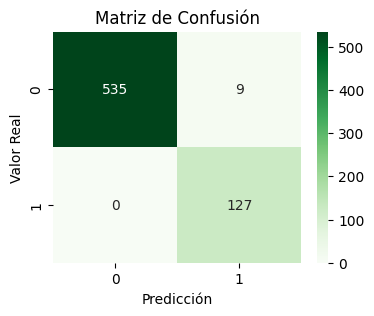

Precisión del modelo: 0.987


In [215]:
# Entrenar el modelo
model = RandomForestClassifier()
model.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
pred = model.predict(x_test)

# Calcular la matriz de confusión
confusion_mat = confusion_matrix(y_test, pred)

# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Greens")
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, pred)
print(f'Precisión del modelo: {accuracy:.3f}')


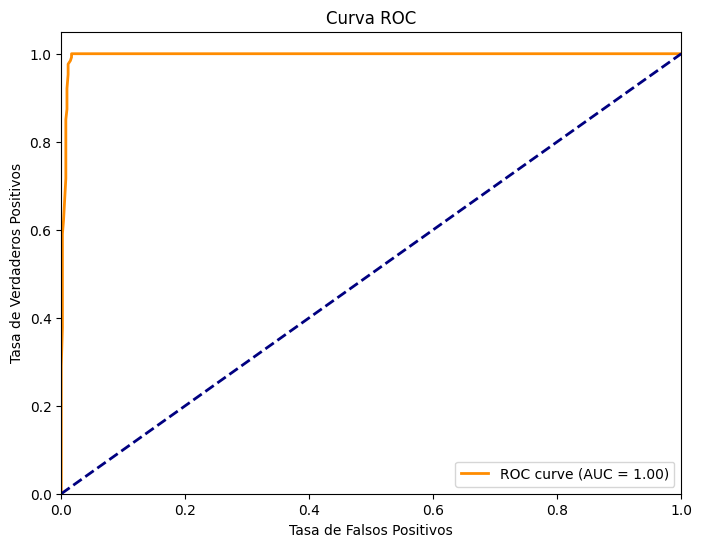

In [216]:
# Curva ROC
# Calcular las puntuaciones de probabilidad para las clases positivas
probs = model.predict_proba(x_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, probs)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = roc_auc_score(y_test, probs)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()


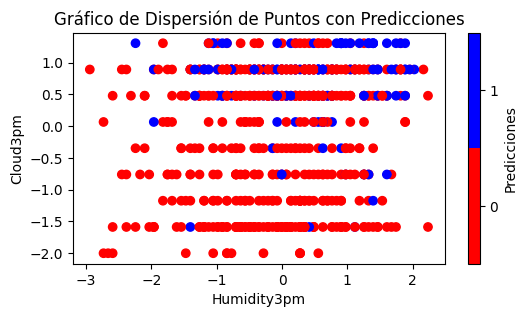

In [217]:
# Suponiendo que 'x_test' tiene al menos dos características
feature1_index = 11  # Índice de la primera característica
feature2_index = 16  # Índice de la segunda característica

# Crear un mapa de colores personalizado para la leyenda
cmap = ListedColormap(['red', 'blue'])  # Rojo (0) y Verde (1)

plt.figure(figsize=(6, 3))
scatter = plt.scatter(x_test[:, feature1_index], x_test[:, feature2_index], c=pred, cmap=cmap)
plt.xlabel('Humidity3pm')
plt.ylabel('Cloud3pm')
plt.title('Gráfico de Dispersión de Puntos con Predicciones')

# Agregar una barra de colores personalizada para la leyenda
plt.colorbar(scatter, ticks=[0, 1], label='Predicciones', boundaries=[-0.5, 0.5, 1.5])

plt.show()
